# 주택 가격 예측: 회귀 문제

## 코드 3-24 보스턴 주택 데이터셋 로드하기
1970년 중반 보스턴 외각 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값 예측하기.
506개의 데이터 포인트, 404개의 훈련 샘플, 102개의 테스트 샘플

In [4]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = 
 boston_housing.load_data()

Using TensorFlow backend.


## 코드 3-25 데이터 정규화
데이터를 특성별로 정규화 시킴. (입력 데이터 행렬의 열 등)               
※ 테스트 데이터에서 계산한 어떤 값도 사용해서는 안된다.

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 코드 3-26 모델 정의하기
64개의 유닛을 가진 2개의 은닉층으로 작은 네트워크를 구성하여 사용           
※훈련 데이터 개수가 적을수록 과대적합이 쉽게 일어난다. 작은 모델을 사용하는 것이 과대적합을 피하는 한 방법이다.

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## 코드 3-27 K-겹 검증하기
K-겹 교차 검증을 데이터 분할 평가하기                        
폴드 1 = 검증 훈련 훈련                           
폴드 2 = 훈련 검증 훈련                       
폴드 3 = 훈련 훈련 검증                      

In [7]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))

W0729 10:14:25.838456 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 10:14:25.865973 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 10:14:25.870361 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 10:14:25.952685 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



처리중인 폴드 # 0


W0729 10:14:26.204864 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0729 10:14:26.213049 16496 deprecation_wrapper.py:119] From C:\Users\lymmo\AppData\Roaming\Python\Python37\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
[2.094319769651583, 2.254353419388875, 2.9004398714197746, 2.3920836873573834]
2.4102991869544037


## 코드 3-28 각 폴드에서 검증 점수를 로그에 저장하기
신경망을 500 에포크 동안 훈련후 모델의 개선점을 로그에 저장

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


## 코드 3-29 K-겹 검증 점수 평균을 기록하기
모든 폴드에 대해 에포크의 MAE 점수 평균을 계산.

In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 코드 3-30 검증 점수 그래프

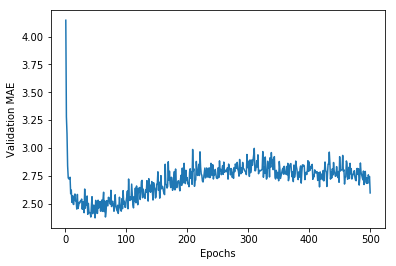

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

fig5 = plt.gcf()
fig5.savefig('fig5.png', dpi=100)
plt.show()

## 코드 3-31 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
각 포인트를 이전 포인트의 지수 이동 평균으로 대체

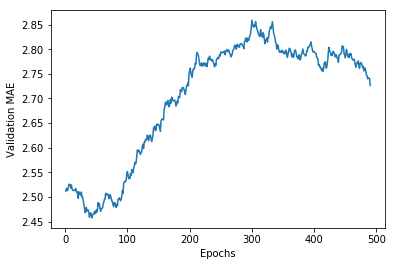

In [12]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 코드 3-32 최종 모델 훈련하기
결과 : 약 2,688$

In [13]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

print(test_mae_score)

102/102 [==============================] - 0s 2ms/step
2.6880473623088763
